In [10]:
%load_ext autoreload
%autoreload 2
import os
import shutil
if not os.path.exists('configs'): get_ipython().run_line_magic('cd', '..')

from utils import plot_utils as putils
custom_color_dict = putils.set_matplotlib_params()

from preprocessing.preprocessing_utils import Backup, get_data_paths, get_figure_path
asset_path, data_path = get_data_paths('./configs')
figure_path = get_figure_path('./configs')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Standard library imports
from pathlib import Path
from datetime import datetime
import json
import pickle
from collections import defaultdict

# Data handling and preprocessing
import pandas as pd
import numpy as np

# Geospatial data handling
import cartopy.crs as ccrs

# Visualization
import matplotlib.pyplot as plt

# Parallel processing
from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import cm


In [12]:
cat_c = ['darkorange', 'crimson', 'indigo', 'dodgerblue']

# 여러 해의 데이터를 읽고 concat하여 고유한 'num' 값만 남기기
pos = pd.concat(
    pd.read_csv(Path(figure_path, 'region', f'region_data_{year}.csv'))
    for year in [2020, 2021, 2022]
).drop_duplicates(subset=['num'])

# 'year' 컬럼 삭제하고 'cat' 컬럼 생성
pos = pos.drop(columns=['year'])
pos = pos.rename(columns={'priority': 'cat'})
pos = pos.sort_values(by='num').reset_index(drop=True)
pos.head()

,num,lon,lat,cat
0,4821,126.544771,33.273132,3
1,5565,126.491969,33.501242,3
2,5566,126.546631,33.500946,3
3,5567,126.601292,33.500620,3
4,8994,126.610883,34.550807,3


In [13]:
output_path_1 = Path('./output/with_units/24-7-25/9-15-1')
output_path_2 = Path('./output/without_units/24-7-25/9-15-6')

region_pearson_1 = pd.read_csv(Path(output_path_1, 'category_pearson.csv'))
region_pearson_2 = pd.read_csv(Path(output_path_2, 'category_pearson.csv'))

for region_pearson in [region_pearson_1, region_pearson_2]:
    for col in ['lon', 'lat', 'cat']:
        region_pearson[col] = region_pearson['num'].map(pos.set_index('num')[col])
    region_pearson = region_pearson.sort_values(by=['val_year','num']).reset_index(drop=True)
    region_pearson = region_pearson[['val_year', 'num', 'lon', 'lat', 'cat', 'pearson']]

In [14]:
region_pearson_1.head()

,val_year,num,pearson,lon,lat,cat
0,2020,5565,0.973889,126.491969,33.501242,3
1,2020,5566,0.969243,126.546631,33.500946,3
2,2020,5567,0.971771,126.601292,33.500620,3
3,2020,9735,0.975366,126.390101,34.780726,3
4,2020,9736,0.968400,126.445829,34.780487,3


In [15]:
cmap=plt.cm.turbo
vmin=0.93
vmax=0.99
goodwhite = 'snow'

norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm_log = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm_log.set_array([])

___

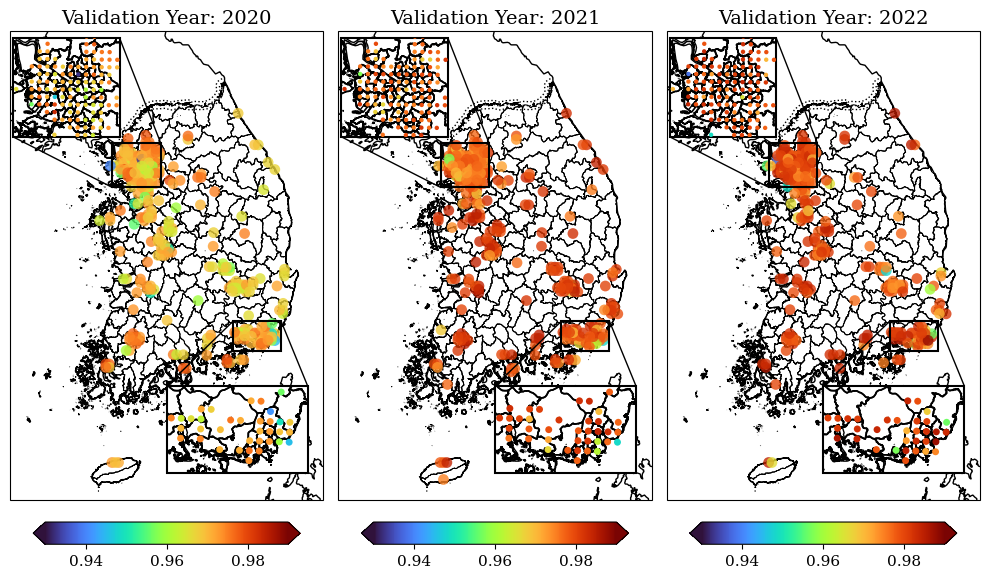

In [16]:
#val_year = 2022
region_pearson, opt = [(region_pearson_1, 'with_units'), (region_pearson_2, 'without_units')][1]

# Setup the figure and axis with Cartopy projection
fig, axs = plt.subplots(1, 3, figsize=(10, 6.1), subplot_kw={'projection': ccrs.PlateCarree()})

for val_year, ax in zip([2020, 2021, 2022], axs):
    # Plot South Korea
    putils.plot_korea(figure_path, ax, 124.8, 130.0, 33.0, 39.3)

    # make scatter plot
    year_mask = region_pearson['val_year'] == val_year
    random_perm = np.random.permutation(len(region_pearson[year_mask]))
    lons = region_pearson[year_mask]['lon'].values[random_perm]
    lats = region_pearson[year_mask]['lat'].values[random_perm]
    pearsons = region_pearson[year_mask]['pearson'].values[random_perm]
    colors = cmap(norm(pearsons))

    ax.scatter(lons, lats, s=60, alpha=0.80, edgecolor='none', c=colors, zorder=99)

    x1, x2, y1, y2 = 126.5, 127.3, 37.2, 37.8
    axins1 = ax.inset_axes([0.01, 0.77, 0.34, 0.22], projection=ccrs.PlateCarree(), xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    putils.plot_korea(figure_path, axins1, x1, x2, y1, y2, zorder_base=50, boundary_lw=1.2)
    putils.zoom_line(ax, axins1)
    axins1.scatter(lons, lats, s=10, alpha=1.0, edgecolor='none', c=colors, zorder=99)

    x1, x2, y1, y2 = 128.5, 129.3, 35.0, 35.4
    axins1 = ax.inset_axes([0.50, 0.03, 0.45, 0.24], projection=ccrs.PlateCarree(), xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    putils.plot_korea(figure_path, axins1, x1, x2, y1, y2, zorder_base=50, boundary_lw=1.2)
    putils.zoom_line(ax, axins1)
    axins1.scatter(lons, lats, s=25, alpha=1.0, edgecolor='none', c=colors, zorder=99)

    cbar = fig.colorbar(sm_log, ax=ax, orientation='horizontal', fraction=0.04, pad=0.04, aspect=12, extend='both')
    # set fontsize
    cbar.ax.tick_params(labelsize=11)

    # Set the title
    ax.set_title(f'Validation Year: {val_year}', fontsize=14)

fig.tight_layout()  # Adjust the layout to make room for the legen
fig.savefig(Path(figure_path, f'region_pearson_{opt}.png'), dpi=600)

___

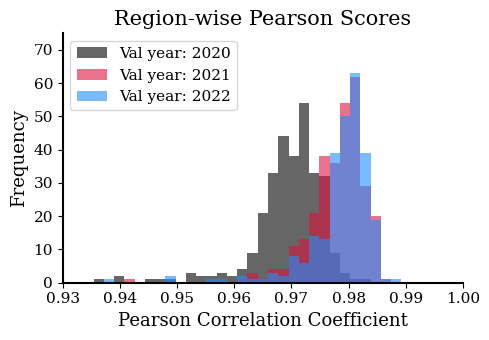

In [17]:
fsize1 = 15
fsize2 = 13
fsize3 = 11
fsize4 = 9

val_year_color = ['black', 'crimson', 'dodgerblue']
region_pearson, opt = [(region_pearson_1, 'with_units'), (region_pearson_2, 'without_units')][0]

# Setup the figure and axis with Cartopy projection
fig = plt.figure(figsize=(5, 3.5))
ax = fig.gca()

bins_list = np.linspace(0.93, 1.00, 40)

for val_year in [2020, 2021, 2022]:
    year_mask = region_pearson['val_year'] == val_year
    pearsons = region_pearson[year_mask]['pearson'].values
    ax.hist(pearsons, bins=bins_list, alpha=0.6, color=val_year_color[val_year-2020], label=f'Val year: {val_year}')

ax.set_xlabel('Pearson Correlation Coefficient', fontsize=fsize2)
ax.set_ylabel('Frequency', fontsize=fsize2)
ax.set_title('Region-wise Pearson Scores', fontsize=fsize1)

ax.set_xlim(0.93, 1.00)
ax.set_ylim(0, 75)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=fsize3)
ax.legend(fontsize=fsize3, loc='upper left')

fig.tight_layout()
fig.savefig(Path(figure_path, f'region_pearson_hist_{opt}.png'), dpi=600)

____

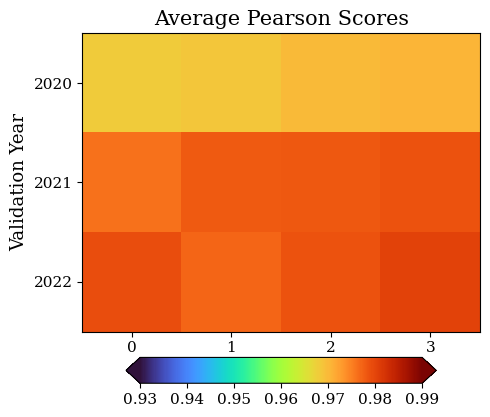

In [25]:
region_pearson, opt = [(region_pearson_1, 'with_units'), (region_pearson_2, 'without_units')][0]

val_year_list = [2020, 2021, 2022]
cat_list = [0, 1, 2, 3]

parr = np.zeros((len(val_year_list), len(cat_list)))
for i, val_year in enumerate(val_year_list):
    for j, cat in enumerate(cat_list):
        year_mask = region_pearson['val_year'] == val_year
        cat_mask = region_pearson['cat'] == cat
        parr[i, j] = region_pearson[year_mask & cat_mask]['pearson'].mean()

fig = plt.figure(figsize=(5, 7))
ax = fig.gca()

ax.imshow(parr, cmap='turbo', vmin=0.93, vmax=0.99)

ax.set_xlabel('Category', fontsize=fsize2)
ax.set_ylabel('Validation Year', fontsize=fsize2)
ax.set_title('Average Pearson Scores', fontsize=fsize1)

ax.set_xticks(np.arange(len(cat_list)))
ax.set_xticklabels(cat_list, fontsize=fsize3)
ax.set_yticks(np.arange(len(val_year_list)))
ax.set_yticklabels(val_year_list, fontsize=fsize3)

cbar = fig.colorbar(sm_log, ax=ax, orientation='horizontal', fraction=0.04, pad=0.04, aspect=12, extend='both')
# set fontsize
cbar.ax.tick_params(labelsize=11)

fig.tight_layout()